# Previsão de Demanda de Item para cada Loja

Neste simples projeto, encontramos uma ótima solução para o desafio proposto pelo Kaggle: [Store Item Demand Forecasting Challenge](https://www.kaggle.com/c/demand-forecasting-kernels-only/overview). Resolvemos tal desafio utilizando técnicas simples e descomplicadas. Com isso mostramos que interpretar, entender e modelar os dados é muito mais relevante e decisivo do que simplesmente utilizar modelos sofisticados

## Importando as Bibliotecas

In [111]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import HTML
from fbprophet import Prophet 
# O Prophet é um pacote usado gerado pelo Facebook. Ele implementa um algoritmo de previsão de séries temporais, programado para detectar automaticamente os padrões sazonais de uma série.

## Definindo Funções Auxiliares

In [112]:
# Definindo uma função para gerar tabelas na mesma linha
def multi_table(table_list):
    return HTML (
        '<table><tr>' + 
        ''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list]) +
        '</tr></table>'
                )

# Definindo a métrica de avaliação SMAPE
def smape(preds, y):
    preds = preds.to_numpy()
    y = y.to_numpy()
    ind = np.where((y!=0)|(preds!=0))
    return 100*np.sum(np.abs(preds[ind] - y[ind])/((np.abs(preds[ind]) + np.abs(y[ind]))/2))/len(y)

## Coletando e Visualizando os Dados

In [113]:
PATH = "datasets"
train_raw = pd.read_csv(f"{PATH}/train.csv", parse_dates=['date'])
test_raw = pd.read_csv(f"{PATH}/test.csv", parse_dates=['date'])

In [114]:
data_train = train_raw.copy()
data_train.index.name = 'id'
data_test = test_raw.copy()
data_test.set_index('id',inplace=True)
multi_table([data_train,data_test])

,date,store,item,sales
id,,,,
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74


## Explorando Características dos Dados

In [115]:
# Verificando valores ausentes e formato das variáveis
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB


In [116]:
# Verificando informações sobre os valores
display(data_train.describe(),data_train.value_counts(['store','item'],sort=False), 
        data_test.value_counts(['store','item'],sort=False))

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


store  item
1      1       1826
       2       1826
       3       1826
       4       1826
       5       1826
               ... 
10     46      1826
       47      1826
       48      1826
       49      1826
       50      1826
Length: 500, dtype: int64

store  item
1      1       90
       2       90
       3       90
       4       90
       5       90
               ..
10     46      90
       47      90
       48      90
       49      90
       50      90
Length: 500, dtype: int64

## Analisando a Quantidade de Vendas para cada Item e Loja

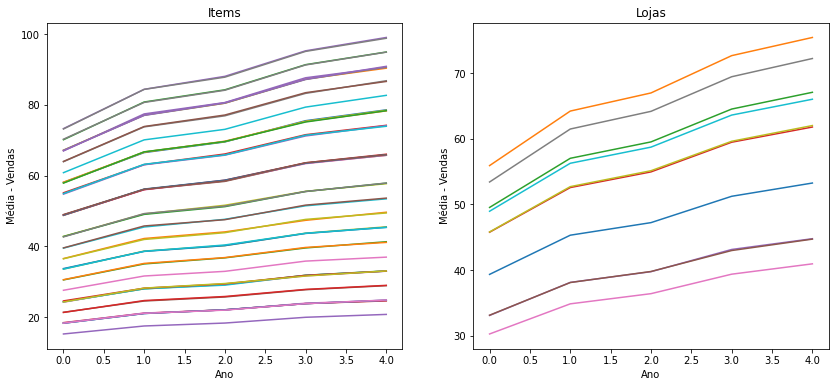

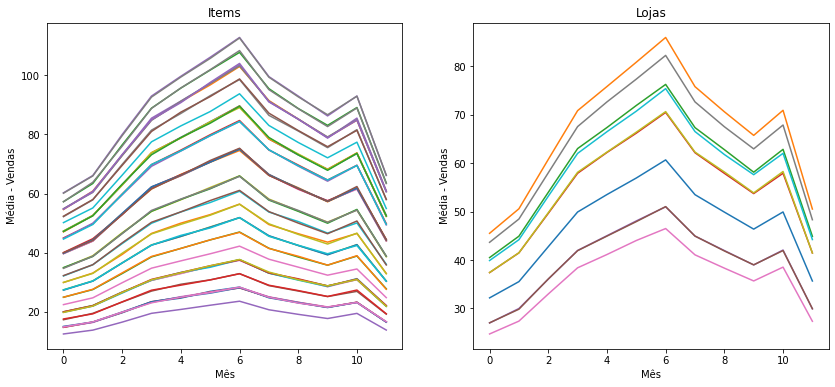

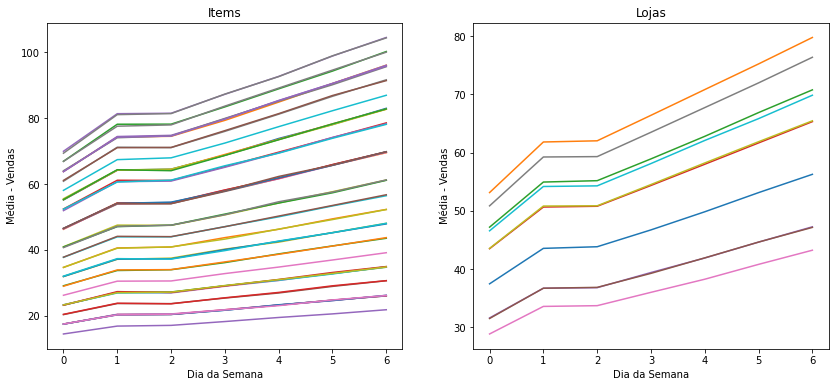

In [117]:
# Visualizando a média de vendas em relação a itens e lojas
def plot_item_store(period='year', xlabel='Ano'):
    agg_year_item = pd.pivot_table(train_raw, index=np.array(getattr(data_train['date'].dt,period)), columns='item', values='sales').values
    agg_year_store = pd.pivot_table(train_raw, index=np.array(getattr(data_train['date'].dt,period)), columns='store', values='sales').values

    plt.figure(figsize=(14, 6))
    plt.subplot(121)
    plt.plot(agg_year_item)
    plt.title("Itens")
    plt.xlabel(xlabel)
    plt.ylabel("Média - Vendas")
    plt.subplot(122)
    plt.plot(agg_year_store)
    plt.title("Lojas")
    plt.xlabel(xlabel)
    plt.ylabel("Média - Vendas")
    plt.show()

plot_item_store(period='year', xlabel='Ano')
plot_item_store(period='month', xlabel='Mês')
plot_item_store(period='dayofweek', xlabel='Dia da Semana')


Nota-se um comportamento similar entre itens e lojas

## Uilizando o Prophet

In [118]:
# Definindo uma função para separar e adequar os dados ao modelo em questão
def split_store_item(df=data_train):
    list_store_item = []
    for i in range(1,len(df['store'].unique())+1):
        for t in range(1,len(df['item'].unique())+1):
            data_it = df[(df['store']==i) & (df['item']==t)].copy()
            data_it.drop(columns=['store','item'],inplace=True)
            data_it.rename(columns={'date':'ds','sales':'y'},inplace=True)
            data_it.name = {'store':i,'item':t}
            list_store_item.append(data_it)
    return list_store_item

In [119]:
# Definindo uma função para rodar o modelo
def run_prophet(train, val):
    prophet = Prophet(yearly_seasonality=True)
    # prophet.add_seasonality(name='90days', period=90, fourier_order=2)
    prophet.fit(train)
    
    future = prophet.make_future_dataframe(90, include_history=False)
    fcst = prophet.predict(future)
        
    return prophet, fcst, smape(val['y'], fcst['yhat'])

In [120]:
# Definindo uma lista com os valores SMAPE obtidos
list_smape_prophet = []
for df in split_store_item()[:30]:
    val_prop = df[df['ds'].isin(pd.date_range('2017-01-01','2017-03-31'))]
    train_prop = df[df['ds'].isin(pd.date_range('2013-01-01','2016-12-31'))]
    score = run_prophet(train_prop, val_prop)[-1]
    list_smape_prophet.append(score)


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

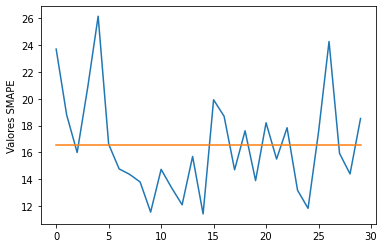

Média: 16.527


In [121]:
# Plotando os valores junto com uma média obtida via amostra de 30 casos
df_prop = pd.DataFrame(list_smape_prophet)
df_prop['mean'] = pd.Series(list_smape_prophet).mean()
plt.ylabel('Valores SMAPE')
plt.plot(df_prop)
plt.show()
print('Média:', round(pd.Series(list_smape_prophet).mean(),4))

## Entendendo melhor o problema

In [122]:
# Expandindo a Tabela para melhor exploração dos dados
def expand_df(df):
    data = df.copy()
    data.set_index('date',inplace=True)
    data['day'] = data.index.day
    data['month'] = data.index.month
    data['year'] = data.index.year
    data['dayofweek'] = data.index.dayofweek
    return data

expanded_data = expand_df(data_train)
expanded_data

,store,item,sales,day,month,year,dayofweek
date,,,,,,,
2013-01-01,1,1,13,1,1,2013,1
2013-01-02,1,1,11,2,1,2013,2
2013-01-03,1,1,14,3,1,2013,3
2013-01-04,1,1,13,4,1,2013,4
2013-01-05,1,1,10,5,1,2013,5
...,...,...,...,...,...,...,...
2017-12-27,10,50,63,27,12,2017,2
2017-12-28,10,50,59,28,12,2017,3
2017-12-29,10,50,74,29,12,2017,4


### Entendendo melhor a relação entre venda, dia da semana, mês e ano

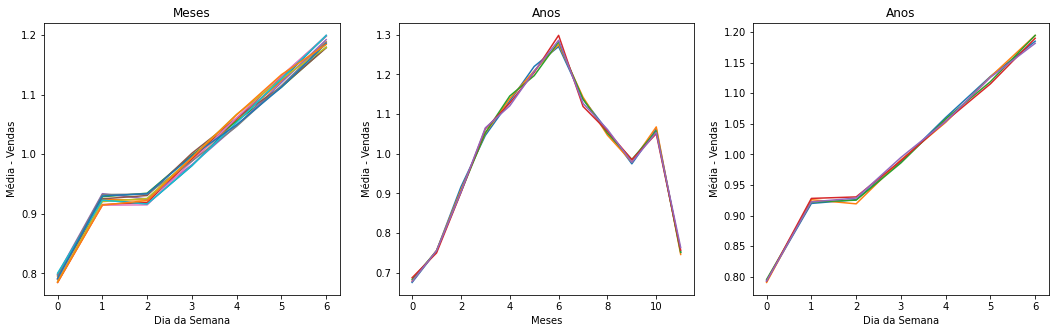

In [123]:
agg_dow_month = pd.pivot_table(expanded_data, index='dayofweek', columns='month',
                               values='sales').values
agg_month_year = pd.pivot_table(expanded_data, index='month', columns='year',
                                values='sales').values
agg_dow_year = pd.pivot_table(expanded_data, index='dayofweek', columns='year',
                              values='sales').values

# Dessa vez dividiremos pela média a fim de entendermos melhor o comportamento de cada caso
plt.figure(figsize=(18, 5))
plt.subplot(131)
plt.plot(agg_dow_month / agg_dow_month.mean(0)[np.newaxis])
plt.title("Meses")
plt.xlabel("Dia da Semana")
plt.ylabel("Média - Vendas")
plt.subplot(132)
plt.plot(agg_month_year / agg_month_year.mean(0)[np.newaxis])
plt.title("Anos")
plt.xlabel("Meses")
plt.ylabel("Média - Vendas")
plt.subplot(133)
plt.plot(agg_dow_year / agg_dow_year.mean(0)[np.newaxis])
plt.title("Anos")
plt.xlabel("Dia da Semana")
plt.ylabel("Média - Vendas")
plt.show()

Note que, neste caso, podemos efetivamente tratar o "mês", "ano", "dia da semana" como modificadores completamente independentes para a previsão de vendas. Isso nos permite considerar um modelo de previsão mais simples.

Uma vez que existem padrões muito regulares nas tendências de "mês", "dia da semana" e "ano". Tudo o que precisamos fazer é simplesmente memorizar essas tendências e aplicá-las às nossas previsões, multiplicando-as pelas vendas médias esperadas.

### Entendendo melhor a Relação entre Itens e Lojas

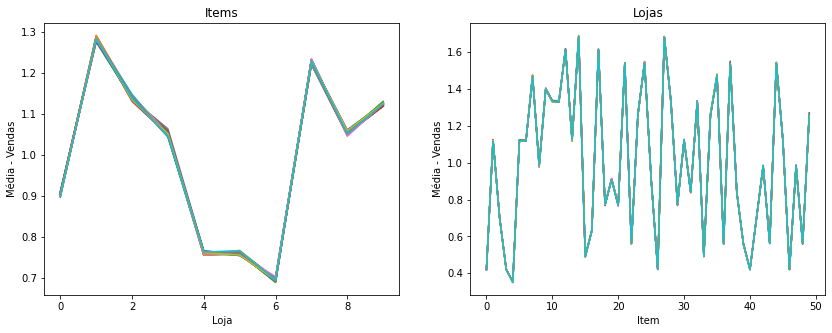

In [124]:
agg_store_item = pd.pivot_table(expanded_data, index='store', columns='item',
                                values='sales').values

plt.figure(figsize=(14, 5))
plt.subplot(121)
plt.plot(agg_store_item / agg_store_item.mean(0)[np.newaxis])
plt.title("Itens")
plt.xlabel("Loja")
plt.ylabel("Média - Vendas")
plt.subplot(122)
plt.plot(agg_store_item.T / agg_store_item.T.mean(0)[np.newaxis])
plt.title("Lojas")
plt.xlabel("Item")
plt.ylabel("Média - Vendas")
plt.show()

Nota-se um padrão constante. Desta forma, precisamos apenas de um modelo que ilustra como os itens são vendidos em diferentes lojas. Isso pode ser facilmente capturado por uma tabela de consulta de vendas médias.

item,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
store,,,,,,,,,,,,,,,,,,,,,
1,19.971522,53.148959,33.208105,19.956188,16.612815,53.060789,52.783680,69.472070,46.504929,66.354326,...,20.002738,33.105696,46.242607,26.594195,72.720701,52.845016,19.814348,46.546002,26.461665,59.342826
2,28.173604,75.316539,46.992333,28.234940,23.540526,74.945235,75.058598,99.090361,65.478094,94.097481,...,28.069551,47.368018,65.785323,37.785871,103.381161,75.219606,28.187842,66.028478,37.711939,84.622125
3,25.070099,66.804491,41.771084,25.116101,20.857612,67.007119,66.647864,87.517525,58.486857,83.387733,...,24.989047,41.797371,58.197700,33.386090,91.851041,66.748083,25.120482,58.700986,33.259584,74.958379
4,22.938664,61.715225,38.548193,23.086528,19.525192,61.270537,61.625411,80.819825,54.043812,77.047645,...,23.168127,38.539978,54.018620,30.952355,84.687295,61.420044,23.114458,53.765608,30.840635,68.921687
5,16.739321,44.488499,27.835706,16.776561,14.086528,44.564622,44.535597,58.565717,38.837349,55.509858,...,16.830778,27.730559,39.163198,22.415115,61.427163,44.734940,16.699343,39.281490,22.371851,50.319277
6,16.717963,44.533954,27.811062,16.754107,13.893209,44.503834,44.599124,58.385542,39.460022,55.565170,...,16.607338,27.893209,39.034502,22.322563,61.142935,44.539978,16.708653,39.052574,22.181271,50.516429
7,15.159365,40.717963,25.531216,15.358160,12.733844,40.703724,40.709748,53.723987,35.901972,51.156627,...,15.471522,25.435926,35.426068,20.446331,55.905805,40.828587,15.479189,35.624315,20.406353,45.823658
8,26.983571,71.656627,45.076123,26.948521,22.427711,71.958379,71.730559,94.461117,63.193319,89.818182,...,27.036145,45.144031,62.980285,36.194414,98.941402,72.004929,27.150055,62.737130,36.035049,80.972070
9,23.325849,61.792442,38.535049,23.150055,19.272180,61.412377,61.812158,81.287514,54.105696,77.105148,...,23.191128,38.643483,54.152793,30.968237,85.093647,62.010953,23.003286,53.976999,31.052574,69.308324


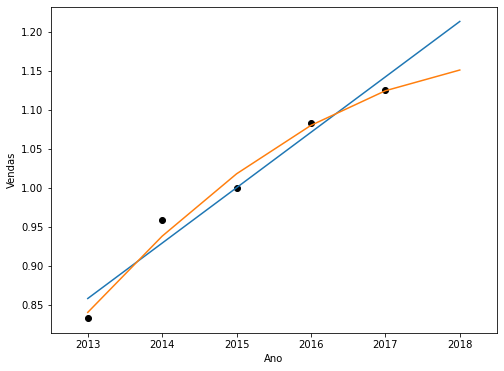

In [125]:
# Obtendo a média de vendas
grand_avg = expanded_data.sales.mean()

# Tabela de Lojas e Itens
store_item_table = pd.pivot_table(expanded_data, index='store', columns='item',
                                  values='sales', aggfunc=np.mean)
display(store_item_table)

# Vendas - Mês 
month_table = pd.pivot_table(expanded_data, index='month', values='sales', aggfunc=np.mean)
month_table.sales /= grand_avg

# Vendas - Dia da Semana
dow_table = pd.pivot_table(expanded_data, index='dayofweek', values='sales', aggfunc=np.mean)
dow_table.sales /= grand_avg

# Vendas - Ano
year_table = pd.pivot_table(expanded_data, index='year', values='sales', aggfunc=np.mean)
year_table /= grand_avg

years = np.arange(2013, 2019)
annual_sales_avg = year_table.values.squeeze()

p1 = np.poly1d(np.polyfit(years[:-1], annual_sales_avg, 1))
p2 = np.poly1d(np.polyfit(years[:-1], annual_sales_avg, 2))

plt.figure(figsize=(8,6))
plt.plot(years[:-1], annual_sales_avg, 'ko')
plt.plot(years, p1(years), 'C0-')
plt.plot(years, p2(years), 'C1-')
plt.xlim(2012.5, 2018.5)
plt.ylabel("Vendas")
plt.xlabel("Ano")
plt.show()


Podemos fazer uma regressão linear simples nos pontos devido seu crescimento anual. Mas se olharmos com atenção, temos que o crescimento está diminuindo. O ajuste quadrático funciona melhor, pois captura melhor a curvatura na curva de crescimento. Como temos apenas 5 pontos, esse é o ajuste polinomial de grau mais alto que você podemos fazer para evitar overfitting.

## Criando o modelo

In [132]:
# Selecionando o ajuste quadrático
annual_growth = p2

# Defindo a função de aplicação do modelo
def run_model(test):
    submission = pd.DataFrame(columns=['sales'])

    for _, row in test.iterrows():
        dow, month, year = row.date.dayofweek, row.date.month, row.date.year
        item, store = row['item'], row['store']
        base_sales = store_item_table.at[store, item]
        mul = month_table.at[month, 'sales'] * dow_table.at[dow, 'sales']
        pred_sales = base_sales * mul * annual_growth(year)
        submission.loc[row.name]=pred_sales
        submission.index.name='id'

    return submission

In [135]:
# Validando para o ano 2017
dfmodel = data_train.drop(columns='sales')
val_model = dfmodel[dfmodel['date'].isin(pd.date_range('2017-01-01','2017-03-31'))]
validation = run_model(val_model)

In [142]:
real_model = data_train[data_train['date'].isin(pd.date_range('2017-01-01','2017-03-31'))]
smape(real_model['sales'],validation['sales'])


13.176362409613615

Finalmente, obtemos um um bom valor!

In [143]:
# Salvando a previsão
pred = run_model(data_test)
pred.to_csv("output\pred_float.csv", index=True)

# Buscando inteiro mais próximo
pred_round = pred.copy()
pred_round['sales'] = np.round(pred_round['sales']).astype(int)
pred_round.to_csv("output\pred_round.csv", index=True)